In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import itertools
import warnings
import random
warnings.filterwarnings("ignore")
import skimage.measure

from PIL import Image

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.utils import np_utils

from itertools import repeat
from glob import glob

from scipy.optimize import curve_fit

Using TensorFlow backend.


# Data stacking

In [3]:
#Create images from abaqus dat files
directory_img = []
for y in range(180):
    directory_img.append("inputs/dat_file/Imperfection_test_SCRI_" + str(y+1) + "_model.dat")
for DIR,y in zip(directory_img, range(180)):
    data = np.loadtxt(DIR, delimiter = ',')
    plt.imsave('inputs/img_' + str(y+1) + '.png', data )

In [8]:
#output stacking
filenames = []
for y in range(180):
    filenames.append('output/ESC_test_SCRI_' + str(y+1) + '_model_01.dat')
dataframes = [pd.read_table(f, delimiter = ',', skiprows = 1) for f in filenames 
              if not f.endswith('BPs.dat')]#ignore BPs files

labels = []
for y in range(len(dataframes)):
    labels.append(dataframes[y].max()[1])#select the maximum value as the buckling load
    labels_norm = np.array(labels)/np.array(labels).max() #normalize by the maximum value

# Data preprocessing & augmentation

In [5]:
#Load, convert image in desired sized matrix and stack them in one matrix
def gen_dataset(img_size):
    dataset_list = []
    for y in range(180):
        img = load_img('img/img_'+str(y+1)+'.png', grayscale=True) #load image in black & white
        img_resized = img.resize(img_size) #resize the image
        img_array = img_to_array(img_resized) #transform image to array
        #normalize the input
        img_array_norm = (img_array - img_array.min())/(img_array.max()-img_array.min())
        dataset_list.append(img_array_norm) #add to list the normalized image
    dataset = np.stack(dataset_list) #stack the list
    return dataset

In [6]:
def data_augmentation(dataset, labels, samples, augmentation):
    #split the data in test and training sets
    X_train, X_val, y_train, y_val = train_test_split(dataset, labels_norm, test_size=0.2, random_state=12)   
    # split the training data in validation and training set
    X_train_train_to_duplicate, X_train_test, y_train_train_to_duplicate, y_train_test = train_test_split(X_train, y_train, test_size=0.2, random_state=12)   
    if augmentation == 1:
        X_train_list = []
        for i in range(len(X_train_train_to_duplicate[:samples])):
            X_train_tmp = X_train_train_to_duplicate[int(i)]
            X_train_list.append(X_train_tmp)
            X_train_list.append(np.flip(X_train_tmp, axis = 0))#flip image along x axis 
            X_train_list.append(np.flip(X_train_tmp, axis = 1))#flip image along y axis
            X_train_list.append(np.flip(np.flip(X_train_tmp, axis = 0), axis = 1))#flip image along x and y axis
        y_train_train = [x for item in y_train_train_to_duplicate[:samples] for x in repeat(item, 4)]
        X_train_train = np.stack(X_train_list)
    else:
        X_train_train = X_train_train_to_duplicate
        y_train_train = y_train_train_to_duplicate
    return X_train_train, X_train_test, X_val, y_train_train, y_train_test , y_val

## CNN base

In [20]:
def cnn_model(dataset, nf, num_conv_pull, num_dense, num_neur, drop, fs):
    model = Sequential()
    model.add(Conv2D(nf, fs, input_shape=dataset[0].shape, activation='relu'))
    model.add(MaxPooling2D())
    for _ in range(num_conv_pull):
        model.add(Conv2D(nf, fs, activation='relu'))
        model.add(MaxPooling2D())
    model.add(Dropout(drop))
    model.add(Flatten())
    for _ in range(num_dense):
        model.add(Dense(num_neur, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="mean_absolute_percentage_error", optimizer='adamax', metrics = ['mape'])
    return model

## General function for CNN tuning

In [24]:
def tune_cnn(input_shapes, samples, num_filt, num_conv_pull, num_dense, num_neur, dropouts, augm, fs):

    skills = pd.DataFrame(columns = ['input shape','Number of sample', 
                                     'Drop out', 'Number of filters'
                                     'Number of conv and pull layers',
                                     'Number of dense layer', 'Number of neurons', 
                                     'MAPE validation'])
    mape_hist = []
    #data generation
    for (inpt_shape, sample_test, nf, Num_conv_pull, Num_dense, Num_neur, 
         dropout, aug, fs) in itertools.product(input_shapes, samples, num_filt, 
        num_conv_pull, num_dense, num_neur, dropouts, augm, fs):
        
        dataset = gen_dataset(inpt_shape)
        #train test split
        (X_train_train, X_train_test, X_val, y_train_train, y_train_test , 
         y_val) = data_augmentation(dataset, labels_norm, sample_test, aug)
        model = cnn_model(dataset, nf, Num_conv_pull, Num_dense, Num_neur, dropout, fs) 
        #model compilation
        history = model.fit(X_train_train, y_train_train, 
                            validation_data =[X_train_test,y_train_test],
           epochs=50, batch_size=10, verbose = 1)
        #record training history 
        mape_hist.append(history)
        new_row = pd.Series({'input shape': inpt_shape, 
                             'Number of sample':sample_test,
                             'Number of filters':nf,
                             'Drop out':dropout, 
                             'Number of conv and pull layers': Num_conv_pull, 
                             'Number of dense layer': Num_dense, 
                             'Number of neurons': Num_neur,
                             'MAPE validation' : history.history["val_mape"][:-1]
                            })
        skills = skills.append(new_row, ignore_index=True)
    return skills, mape_hist

# CNN tuning

## Number of filters

In [12]:
#general parameters of plot
sns.set(style = 'whitegrid', rc={'figure.figsize':(12,4)})

In [ ]:
input_shapes = [(128,128)]
nf = [8,12,16,20]
samples = [180]
drops = [0.2]
Num_conv_pull = [2]
Num_dense = [2]
Num_neur = [50]
augmentation = [0]
fs = [(3,3)]
sk, mape = tune_cnn(input_shapes, samples, nf, Num_conv_pull,
                    Num_dense, Num_neur, drops, augmentation)

In [ ]:
labels = ["# of filter = 8","# of filter = 12","# of filter = 16","# of filter = 20" ]
for i in range(len(mape)):
    plt.plot(mape[i].history["loss"], label = labels[i])
plt.title("MAPE training with different number of filters")
plt.xlabel("epoch")
plt.ylabel("MAPE training")
plt.legend()
plt.savefig("report/nf_train")

In [ ]:
labels = ["# of filter = 8","# of filter = 12","# of filter = 16","# of filter = 20" ]
for i in range(len(mape)):
    plt.plot(mape[i].history["val_loss"],label = labels[i])    
plt.title("MAPE validation with different number of filters")
plt.xlabel("epoch")
plt.ylabel("MAPE validation")
plt.legend()
plt.savefig("report/nf_val.png")

## Number of convolution and pooling layer

In [112]:
input_shapes = [(128,128)]
nf = [12]
samples = [180]
drops = [0.2]
Num_conv_pull = [1,2,3,4]
Num_dense = [2]
Num_neur = [50]
augmentation = [0]
fs = [(3,3)]
sk, mape = tune_cnn(input_shapes, samples, nf, Num_conv_pull,
                    Num_dense, Num_neur, drops, augmentation)

Train on 115 samples, validate on 29 samples
Epoch 1/50
115/115 [==============================] - 3s 28ms/step - loss: 25.9704 - mape: 25.9704 - val_loss: 16.0960 - val_mape: 16.0960
Epoch 2/50
115/115 [==============================] - 2s 21ms/step - loss: 15.7934 - mape: 15.7934 - val_loss: 12.8798 - val_mape: 12.8798
Epoch 3/50
115/115 [==============================] - 2s 19ms/step - loss: 13.7662 - mape: 13.7662 - val_loss: 10.4226 - val_mape: 10.4226
Epoch 4/50
115/115 [==============================] - 2s 16ms/step - loss: 12.8196 - mape: 12.8196 - val_loss: 11.6219 - val_mape: 11.6219
Epoch 5/50
115/115 [==============================] - 2s 15ms/step - loss: 12.8399 - mape: 12.8399 - val_loss: 10.0479 - val_mape: 10.0479
Epoch 6/50
115/115 [==============================] - 2s 15ms/step - loss: 11.9370 - mape: 11.9370 - val_loss: 10.0087 - val_mape: 10.0087
Epoch 7/50
115/115 [==============================] - 2s 19ms/step - loss: 11.5724 - mape: 11.5724 - val_loss: 10.7230 - 

Epoch 10/50
115/115 [==============================] - 2s 17ms/step - loss: 12.3295 - mape: 12.3295 - val_loss: 10.1531 - val_mape: 10.1531
Epoch 11/50
115/115 [==============================] - 2s 18ms/step - loss: 11.8045 - mape: 11.8045 - val_loss: 9.7574 - val_mape: 9.7574
Epoch 12/50
115/115 [==============================] - 2s 14ms/step - loss: 12.4630 - mape: 12.4630 - val_loss: 9.9852 - val_mape: 9.9852
Epoch 13/50
115/115 [==============================] - 2s 14ms/step - loss: 11.6150 - mape: 11.6150 - val_loss: 9.9205 - val_mape: 9.9205
Epoch 14/50
115/115 [==============================] - 2s 14ms/step - loss: 10.9280 - mape: 10.9280 - val_loss: 10.7649 - val_mape: 10.7649
Epoch 15/50
115/115 [==============================] - 2s 14ms/step - loss: 11.4434 - mape: 11.4434 - val_loss: 13.0333 - val_mape: 13.0333
Epoch 16/50
115/115 [==============================] - 2s 16ms/step - loss: 10.8700 - mape: 10.8700 - val_loss: 8.9005 - val_mape: 8.9005
Epoch 17/50
115/115 [=======

115/115 [==============================] - 3s 26ms/step - loss: 9.9387 - mape: 9.9387 - val_loss: 9.7270 - val_mape: 9.7270
Epoch 29/50
115/115 [==============================] - 3s 26ms/step - loss: 9.6332 - mape: 9.6332 - val_loss: 8.7981 - val_mape: 8.7981
Epoch 30/50
115/115 [==============================] - 4s 38ms/step - loss: 9.3827 - mape: 9.3827 - val_loss: 9.2872 - val_mape: 9.2872
Epoch 31/50
115/115 [==============================] - 4s 33ms/step - loss: 9.1608 - mape: 9.1608 - val_loss: 7.5241 - val_mape: 7.5241
Epoch 32/50
115/115 [==============================] - 4s 33ms/step - loss: 9.9664 - mape: 9.9664 - val_loss: 7.3198 - val_mape: 7.3198
Epoch 33/50
115/115 [==============================] - 3s 30ms/step - loss: 9.1608 - mape: 9.1608 - val_loss: 7.3278 - val_mape: 7.3278
Epoch 34/50
115/115 [==============================] - 4s 37ms/step - loss: 8.8797 - mape: 8.8797 - val_loss: 7.6067 - val_mape: 7.6067
Epoch 35/50
115/115 [==============================] - 4s 34

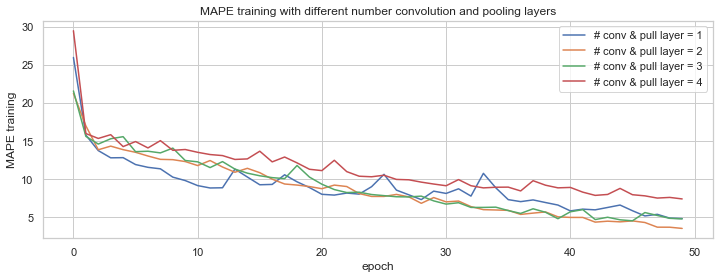

In [113]:
labels = ["# conv & pull layer = 1","# conv & pull layer = 2","# conv & pull layer = 3","# conv & pull layer = 4"]
for i in range(len(mape)):
    plt.plot(mape[i].history["loss"], label = labels[i])
plt.title("MAPE training with different number convolution and pooling layers")
plt.xlabel("epoch")
plt.ylabel("MAPE training")
plt.legend()
plt.savefig("report/cp_train")

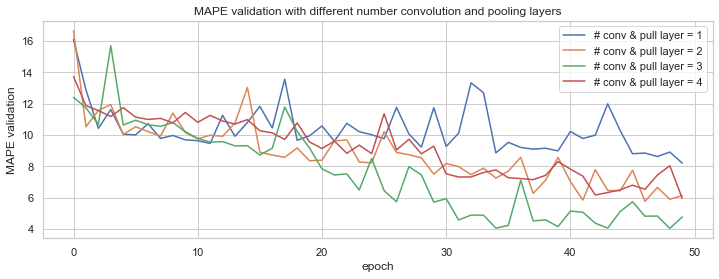

In [114]:
labels = ["# conv & pull layer = 1","# conv & pull layer = 2","# conv & pull layer = 3","# conv & pull layer = 4" ]
for i in range(len(mape)):
    plt.plot(mape[i].history["val_mape"], label = labels[i])
plt.title("MAPE validation with different number convolution and pooling layers")
plt.xlabel("epoch")
plt.ylabel("MAPE validation")
plt.legend()
plt.savefig("report/cp_val")

## Number of neurons 

In [115]:
input_shapes = [(128,128)]
nf = [12]
samples = [180]
drops = [0.2]
Num_conv_pull = [3]
Num_dense = [2]
Num_neur = [50,100,150,200]
augmentation = [0]
fs = [(3,3)]
sk, mape = tune_cnn(input_shapes, samples, nf, Num_conv_pull,
                    Num_dense, Num_neur, drops, augmentation)

Train on 115 samples, validate on 29 samples
Epoch 1/50
115/115 [==============================] - 2s 20ms/step - loss: 18.6896 - mape: 18.6896 - val_loss: 10.8987 - val_mape: 10.8987
Epoch 2/50
115/115 [==============================] - 2s 17ms/step - loss: 14.6417 - mape: 14.6417 - val_loss: 11.3870 - val_mape: 11.3870
Epoch 3/50
115/115 [==============================] - 2s 14ms/step - loss: 14.2238 - mape: 14.2238 - val_loss: 10.5803 - val_mape: 10.5803
Epoch 4/50
115/115 [==============================] - 2s 17ms/step - loss: 14.0481 - mape: 14.0481 - val_loss: 11.4764 - val_mape: 11.4764
Epoch 5/50
115/115 [==============================] - 2s 17ms/step - loss: 14.7727 - mape: 14.7727 - val_loss: 10.3358 - val_mape: 10.3358
Epoch 6/50
115/115 [==============================] - 2s 17ms/step - loss: 13.3393 - mape: 13.3393 - val_loss: 13.0720 - val_mape: 13.0720
Epoch 7/50
115/115 [==============================] - 2s 17ms/step - loss: 15.0368 - mape: 15.0368 - val_loss: 12.4608 - 

115/115 [==============================] - 2s 17ms/step - loss: 12.9762 - mape: 12.9762 - val_loss: 9.7950 - val_mape: 9.7950
Epoch 11/50
115/115 [==============================] - 2s 15ms/step - loss: 11.4421 - mape: 11.4421 - val_loss: 10.3770 - val_mape: 10.3770
Epoch 12/50
115/115 [==============================] - 1s 12ms/step - loss: 10.6653 - mape: 10.6653 - val_loss: 9.8132 - val_mape: 9.8132
Epoch 13/50
115/115 [==============================] - 1s 12ms/step - loss: 10.0161 - mape: 10.0161 - val_loss: 7.7785 - val_mape: 7.7785
Epoch 14/50
115/115 [==============================] - 1s 12ms/step - loss: 9.6306 - mape: 9.6306 - val_loss: 8.1400 - val_mape: 8.1400
Epoch 15/50
115/115 [==============================] - 1s 12ms/step - loss: 10.5875 - mape: 10.5875 - val_loss: 8.0363 - val_mape: 8.0363
Epoch 16/50
115/115 [==============================] - 1s 12ms/step - loss: 9.0554 - mape: 9.0554 - val_loss: 6.9187 - val_mape: 6.9187
Epoch 17/50
115/115 [===========================

Epoch 20/50
115/115 [==============================] - 1s 12ms/step - loss: 8.4385 - mape: 8.4385 - val_loss: 8.0759 - val_mape: 8.0759
Epoch 21/50
115/115 [==============================] - 1s 12ms/step - loss: 8.3454 - mape: 8.3454 - val_loss: 8.5206 - val_mape: 8.5206
Epoch 22/50
115/115 [==============================] - 1s 12ms/step - loss: 7.7545 - mape: 7.7545 - val_loss: 7.1520 - val_mape: 7.1520
Epoch 23/50
115/115 [==============================] - 1s 12ms/step - loss: 8.9731 - mape: 8.9731 - val_loss: 6.2781 - val_mape: 6.2781
Epoch 24/50
115/115 [==============================] - 1s 12ms/step - loss: 7.8837 - mape: 7.8837 - val_loss: 7.8191 - val_mape: 7.8191
Epoch 25/50
115/115 [==============================] - 1s 12ms/step - loss: 7.9369 - mape: 7.9369 - val_loss: 6.4603 - val_mape: 6.4603
Epoch 26/50
115/115 [==============================] - 1s 12ms/step - loss: 6.9039 - mape: 6.9039 - val_loss: 5.4620 - val_mape: 5.4620
Epoch 27/50
115/115 [===========================

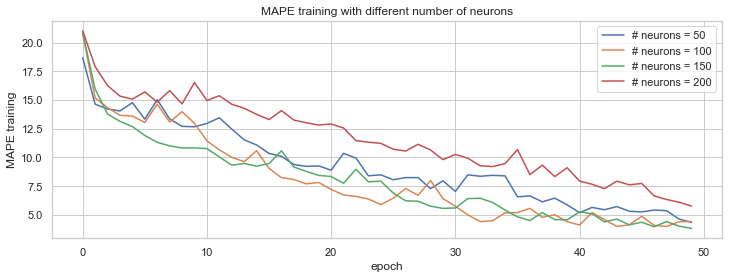

In [116]:
labels = ["# neurons = 50","# neurons = 100","# neurons = 150","# neurons = 200"]
for i in range(len(mape)):
    plt.plot(mape[i].history["loss"], label = labels[i])
plt.title("MAPE training with different number of neurons")
plt.xlabel("epoch")
plt.ylabel("MAPE training")
plt.legend()
plt.savefig("report/neur_train")

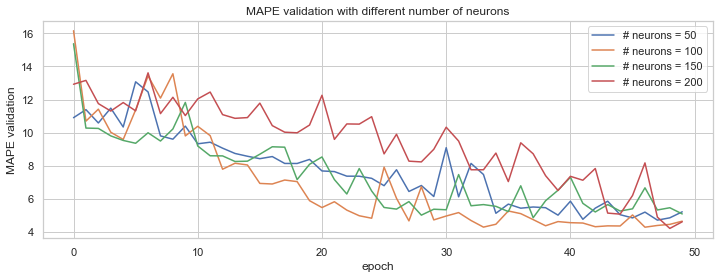

In [117]:
labels = ["# neurons = 50","# neurons = 100","# neurons = 150","# neurons = 200"]
for i in range(len(mape)):
    plt.plot(mape[i].history["val_mape"], label = labels[i])
plt.title("MAPE validation with different number of neurons")
plt.xlabel("epoch")
plt.ylabel("MAPE validation")
plt.legend()
plt.savefig("report/neur_val")

## Dense layers

In [14]:
input_shapes = [(128,128)]
nf = [12]
samples = [180]
drops = [0.2]
Num_conv_pull = [3]
Num_dense = [1,2,3,4]
Num_neur = [100]
augmentation = [0]
fs = [(3,3)]
sk, mape = tune_cnn(input_shapes, samples, nf, Num_conv_pull,
                    Num_dense, Num_neur, drops, augmentation)

Train on 115 samples, validate on 29 samples
Epoch 1/50
115/115 [==============================] - 1s 8ms/step - loss: 18.8558 - mape: 18.8558 - val_loss: 14.8998 - val_mape: 14.8998
Epoch 2/50
115/115 [==============================] - 1s 6ms/step - loss: 14.4685 - mape: 14.4685 - val_loss: 10.8991 - val_mape: 10.8991
Epoch 3/50
115/115 [==============================] - 1s 6ms/step - loss: 14.2189 - mape: 14.2189 - val_loss: 11.1849 - val_mape: 11.1849
Epoch 4/50
115/115 [==============================] - 1s 6ms/step - loss: 13.6473 - mape: 13.6473 - val_loss: 11.0134 - val_mape: 11.0134
Epoch 5/50
115/115 [==============================] - 1s 6ms/step - loss: 14.1209 - mape: 14.1209 - val_loss: 11.5848 - val_mape: 11.5848
Epoch 6/50
115/115 [==============================] - 1s 6ms/step - loss: 13.0768 - mape: 13.0768 - val_loss: 11.3964 - val_mape: 11.3965
Epoch 7/50
115/115 [==============================] - 1s 6ms/step - loss: 12.5934 - mape: 12.5934 - val_loss: 9.8775 - val_mape

Epoch 20/50
115/115 [==============================] - 1s 5ms/step - loss: 10.3970 - mape: 10.3970 - val_loss: 8.8589 - val_mape: 8.8589
Epoch 21/50
115/115 [==============================] - 1s 5ms/step - loss: 10.5682 - mape: 10.5682 - val_loss: 7.6658 - val_mape: 7.6658
Epoch 22/50
115/115 [==============================] - 1s 5ms/step - loss: 9.1526 - mape: 9.1526 - val_loss: 7.3890 - val_mape: 7.3890
Epoch 23/50
115/115 [==============================] - 1s 5ms/step - loss: 9.3038 - mape: 9.3038 - val_loss: 8.8082 - val_mape: 8.8082
Epoch 24/50
115/115 [==============================] - 1s 5ms/step - loss: 8.5017 - mape: 8.5017 - val_loss: 7.2393 - val_mape: 7.2393
Epoch 25/50
115/115 [==============================] - 1s 5ms/step - loss: 8.2185 - mape: 8.2185 - val_loss: 6.9719 - val_mape: 6.9719
Epoch 26/50
115/115 [==============================] - 1s 5ms/step - loss: 10.7882 - mape: 10.7882 - val_loss: 11.3675 - val_mape: 11.3675
Epoch 27/50
115/115 [==========================

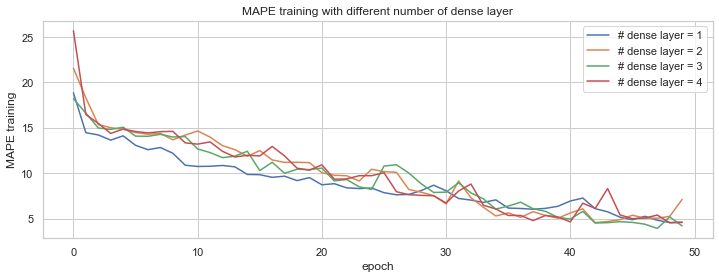

In [17]:
labels = ["# dense layer = 1","# dense layer = 2","# dense layer = 3","# dense layer = 4"]
for i in range(len(mape)):
    plt.plot(mape[i].history["loss"], label = labels[i])
plt.title("MAPE training with different number of dense layer")
plt.xlabel("epoch")
plt.ylabel("MAPE training")
plt.legend()
plt.savefig("report/dense_train")

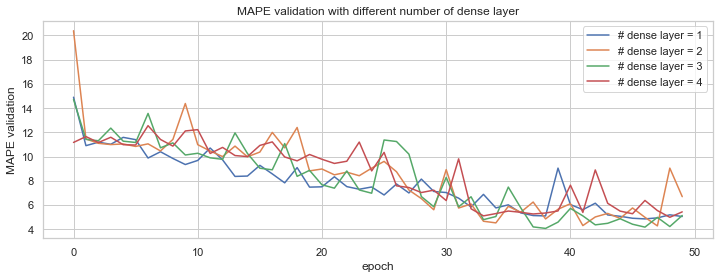

In [18]:
labels = ["# dense layer = 1","# dense layer = 2","# dense layer = 3","# dense layer = 4"]
for i in range(len(mape)):
    plt.plot(mape[i].history["val_mape"], label = labels[i])
plt.title("MAPE validation with different number of dense layer")
plt.xlabel("epoch")
plt.ylabel("MAPE validation")
plt.legend()
plt.savefig("report/dense_val")

## Data augmentation influence

In [138]:
input_shapes = [(128,128)]
nf = [12]
samples = [180]
drops = [0.2]
Num_conv_pull = [3]
Num_dense = [1]
Num_neur = [100]
augmentation = [0,1]
fs = [(3,3)]
sk, mape = tune_cnn(input_shapes, samples, nf, Num_conv_pull,
                    Num_dense, Num_neur, drops, augmentation)

Train on 115 samples, validate on 29 samples
Epoch 1/100
115/115 [==============================] - 1s 7ms/step - loss: 20.9340 - mape: 20.9340 - val_loss: 11.5994 - val_mape: 11.5994
Epoch 2/100
115/115 [==============================] - 1s 5ms/step - loss: 13.8627 - mape: 13.8627 - val_loss: 11.7499 - val_mape: 11.7499
Epoch 3/100
115/115 [==============================] - 1s 5ms/step - loss: 14.0535 - mape: 14.0535 - val_loss: 10.4409 - val_mape: 10.4409
Epoch 4/100
115/115 [==============================] - 1s 5ms/step - loss: 14.2158 - mape: 14.2158 - val_loss: 11.3572 - val_mape: 11.3572
Epoch 5/100
115/115 [==============================] - 1s 5ms/step - loss: 13.5673 - mape: 13.5673 - val_loss: 10.3526 - val_mape: 10.3526
Epoch 6/100
115/115 [==============================] - 1s 5ms/step - loss: 12.4503 - mape: 12.4503 - val_loss: 10.7144 - val_mape: 10.7144
Epoch 7/100
115/115 [==============================] - 1s 5ms/step - loss: 12.2768 - mape: 12.2768 - val_loss: 9.0305 - v

Epoch 61/100
115/115 [==============================] - 1s 5ms/step - loss: 4.3915 - mape: 4.3915 - val_loss: 6.2389 - val_mape: 6.2389
Epoch 62/100
115/115 [==============================] - 1s 5ms/step - loss: 4.5797 - mape: 4.5797 - val_loss: 5.5427 - val_mape: 5.5427
Epoch 63/100
115/115 [==============================] - 1s 5ms/step - loss: 3.9831 - mape: 3.9831 - val_loss: 4.7629 - val_mape: 4.7629
Epoch 64/100
115/115 [==============================] - 1s 5ms/step - loss: 3.3311 - mape: 3.3311 - val_loss: 4.3062 - val_mape: 4.3062
Epoch 65/100
115/115 [==============================] - 1s 5ms/step - loss: 4.2143 - mape: 4.2143 - val_loss: 6.7492 - val_mape: 6.7492
Epoch 66/100
115/115 [==============================] - 1s 5ms/step - loss: 3.6106 - mape: 3.6106 - val_loss: 4.5940 - val_mape: 4.5940
Epoch 67/100
115/115 [==============================] - 1s 5ms/step - loss: 3.4446 - mape: 3.4446 - val_loss: 5.2355 - val_mape: 5.2355
Epoch 68/100
115/115 [==========================

Epoch 21/100
460/460 [==============================] - 2s 5ms/step - loss: 5.1551 - mape: 5.1551 - val_loss: 4.4015 - val_mape: 4.4015
Epoch 22/100
460/460 [==============================] - 2s 5ms/step - loss: 5.2015 - mape: 5.2015 - val_loss: 5.9058 - val_mape: 5.9058
Epoch 23/100
460/460 [==============================] - 2s 5ms/step - loss: 5.1438 - mape: 5.1438 - val_loss: 4.2561 - val_mape: 4.2561
Epoch 24/100
460/460 [==============================] - 2s 5ms/step - loss: 5.5903 - mape: 5.5903 - val_loss: 3.7519 - val_mape: 3.7519
Epoch 25/100
460/460 [==============================] - 2s 5ms/step - loss: 5.3821 - mape: 5.3821 - val_loss: 4.9991 - val_mape: 4.9991
Epoch 26/100
460/460 [==============================] - 2s 5ms/step - loss: 5.2821 - mape: 5.2821 - val_loss: 4.0553 - val_mape: 4.0553
Epoch 27/100
460/460 [==============================] - 2s 5ms/step - loss: 5.1483 - mape: 5.1483 - val_loss: 6.3908 - val_mape: 6.3908
Epoch 28/100
460/460 [==========================

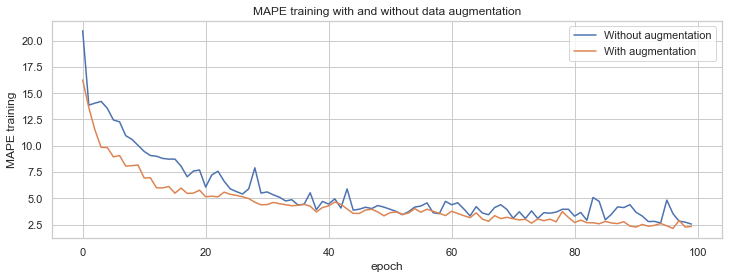

In [139]:
labels = ["Without augmentation","With augmentation"]
for i in range(len(mape)):
    plt.plot(mape[i].history["loss"], label = labels[i])
plt.title("MAPE training with and without data augmentation")
plt.xlabel("epoch")
plt.ylabel("MAPE training")
plt.legend()
plt.savefig("report/aug_train")

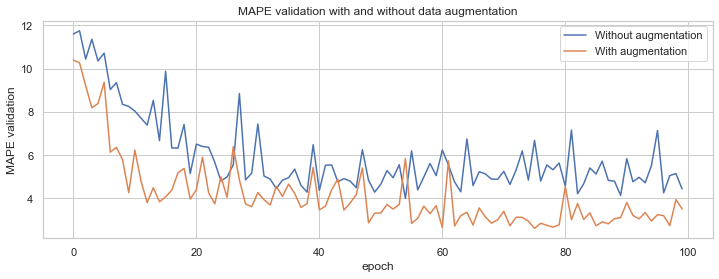

In [140]:
labels = ["Without augmentation","With augmentation"]
for i in range(len(mape)):
    plt.plot(mape[i].history["val_mape"], label = labels[i])
plt.title("MAPE validation with and without data augmentation")
plt.xlabel("epoch")
plt.ylabel("MAPE validation")
plt.legend()
plt.savefig("report/aug_val")

## Final testing on validation set

In [35]:
dataset = gen_dataset((128,128))
#train test split
(X_train_train, X_train_test, X_val, y_train_train, y_train_test , 
 y_val) = data_augmentation(dataset, labels_norm, 180, 1)

model = Sequential()
model.add(Conv2D(12, (3,3), input_shape=dataset[0].shape, activation='relu'))
model.add(MaxPooling2D())
for _ in range(3):
    model.add(Conv2D(12, (3,3), activation='relu'))
    model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Flatten())
for _ in range(1):
    model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="mean_absolute_percentage_error", optimizer='adamax', metrics = ['mape'])

#model compilation
model.fit(X_train_train, y_train_train, 
                    validation_data =[X_train_test,y_train_test],
   epochs=100, batch_size=10, verbose = 1)

Train on 460 samples, validate on 29 samples
Epoch 1/100
460/460 [==============================] - 2s 5ms/step - loss: 17.4475 - mape: 17.4475 - val_loss: 11.4145 - val_mape: 11.4145
Epoch 2/100
460/460 [==============================] - 2s 5ms/step - loss: 15.2732 - mape: 15.2732 - val_loss: 11.2636 - val_mape: 11.2636
Epoch 3/100
460/460 [==============================] - 3s 6ms/step - loss: 14.5601 - mape: 14.5601 - val_loss: 10.9272 - val_mape: 10.9272
Epoch 4/100
460/460 [==============================] - 2s 5ms/step - loss: 13.8301 - mape: 13.8301 - val_loss: 12.3721 - val_mape: 12.3721
Epoch 5/100
460/460 [==============================] - 3s 5ms/step - loss: 13.2421 - mape: 13.2421 - val_loss: 9.9591 - val_mape: 9.9591
Epoch 6/100
460/460 [==============================] - 2s 5ms/step - loss: 12.7991 - mape: 12.7991 - val_loss: 10.0648 - val_mape: 10.0648
Epoch 7/100
460/460 [==============================] - 2s 5ms/step - loss: 10.8544 - mape: 10.8544 - val_loss: 9.2080 - val

Epoch 61/100
460/460 [==============================] - 2s 5ms/step - loss: 3.3301 - mape: 3.3301 - val_loss: 3.6812 - val_mape: 3.6812
Epoch 62/100
460/460 [==============================] - 2s 5ms/step - loss: 3.4493 - mape: 3.4493 - val_loss: 3.6939 - val_mape: 3.6939
Epoch 63/100
460/460 [==============================] - 2s 5ms/step - loss: 3.1000 - mape: 3.1000 - val_loss: 3.4012 - val_mape: 3.4012
Epoch 64/100
460/460 [==============================] - 2s 5ms/step - loss: 2.8121 - mape: 2.8121 - val_loss: 3.7959 - val_mape: 3.7959
Epoch 65/100
460/460 [==============================] - 2s 5ms/step - loss: 3.5663 - mape: 3.5663 - val_loss: 4.2471 - val_mape: 4.2471
Epoch 66/100
460/460 [==============================] - 2s 5ms/step - loss: 3.3761 - mape: 3.3761 - val_loss: 3.5920 - val_mape: 3.5920
Epoch 67/100
460/460 [==============================] - 2s 5ms/step - loss: 3.4827 - mape: 3.4827 - val_loss: 4.1534 - val_mape: 4.1534
Epoch 68/100
460/460 [==========================

In [46]:
final_score = np.mean(np.abs(np.reshape(y_predict, len(y_val)) - y_val)/y_val)

In [47]:
final_score

0.05527313532392256

## Interpolation of critical buckling & amplitude of imperfections normalized

In [4]:
amplitude = []
for DIR,y in zip(directory_img, range(len(directory_img))):
    data = np.loadtxt(DIR, delimiter = ',')
    amplitude.append(np.sqrt(np.sum(data.flatten()**2)))
amplitude_norm = np.array(amplitude)/np.array(amplitude).max()

In [5]:
def func_exp(x, a, b, c):
    return a*np.exp(-b*x)+c
def func_lin(x, a, b, c, d):
    return a-b*x

In [9]:
x= np.linspace(1,180,180)
val_exp, cons_exp = curve_fit(func_exp, x, labels_norm)
val_lin, cons_lin = curve_fit(func_lin, x, amplitude_norm)

In [10]:
print("exponential parameters for a*exp(-b*x) + x : \n a = "+str(val_exp[0])+", b = "+str(val_exp[1])+", c = "+str(val_exp[2]))

exponential parameters for a*exp(-b*x) + x : 
 a = 0.6458704443956614, b = 0.038047207583823635, c = 0.34635904943979445


In [11]:
print("linear parameters for a - bx : \n a = "+str(val_lin[0])+", b = "+str(val_lin[1]))

linear parameters for a - bx : 
 a = 0.8348087883202024, b = 0.0010883275978499363


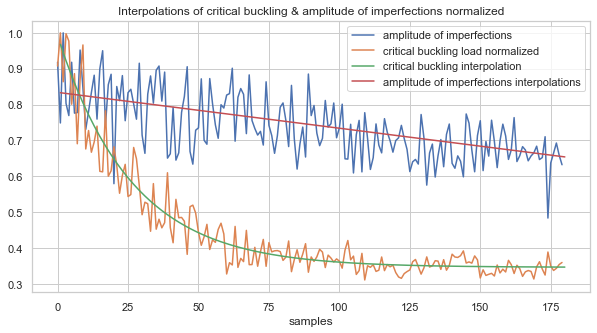

In [204]:
x = np.linspace(1,180,180)
y_samp = 0.834 - 0.001*x
y_lab = 0.646*np.exp(-0.038*(x)) + 0.346
plt.plot(amplitude_norm,label ="amplitude of imperfections")
plt.plot(labels_norm, label = "critical buckling load normalized")
plt.plot(x, y_lab, label = "critical buckling interpolation")
plt.plot(x, y_samp, label = "amplitude of imperfections interpolations")
plt.xlabel("samples")
plt.title("Interpolations of critical buckling & amplitude of imperfections normalized")
plt.legend()
plt.savefig("report/interp")